In [1]:
import numpy as np
import torch
import neurodiffeq as nde
import matplotlib.pyplot as plt

from neurodiffeq import diff

# 2차 미분 방정식을 정의합니다 (예시로 u'' + u' + 2u = 0 를 사용합니다).
def ode_system(u, t):
#    return [diff(u, t, order=2)+u]
    return [diff(u, t, order=2)+diff(u, t, order=1)+2*u]

# 초기 조건과 독립 변수 범위를 설정합니다.
#initial_condition = [nde.conditions.IVP(t_0=0.0, u_0=0.0, u_0_prime=1.0)]  # u(0) = 0, u'(0) = 1
initial_condition = [nde.conditions.IVP(t_0=0.0, u_0=1.0, u_0_prime=0.0)]   # u(0) = 1, u'(0) = 0

# Generator1D 클래스의 인스턴스를 생성하여 훈련, 검증 데이터를 생성합니다.
train_gen = nde.generators.Generator1D(size=1000, t_min=0.0, t_max=5.0, method='equally-spaced-noisy')
valid_gen = nde.generators.Generator1D(size=200, t_min=0.0, t_max=5.0, method='equally-spaced')

#method에 대해서
#If set to 'uniform',
#   the points will be drew from a uniform distribution Unif(t_min, t_max).
#If set to 'equally-spaced',
#   the points will be fixed to a set of linearly-spaced points that go from t_min to t_max.
#If set to 'equally-spaced-noisy', a normal noise will be added to the previously mentioned set of points.
#If set to 'log-spaced', the points will be fixed to a set of log-spaced points that go from t_min to t_max.
#If set to 'log-spaced-noisy', a normal noise will be added to the previously mentioned set of points,
#If set to 'chebyshev1' or 'chebyshev', the points are chebyshev nodes of the first kind over (t_min, t_max).
#If set to 'chebyshev2', the points will be chebyshev nodes of the second kind over [t_min, t_max].

# 신경망 모델 정의 (여기서는 단순한 Fully Connected Neural Network를 사용합니다).
neural_net = [nde.solvers.FCNN(n_hidden_layers=6, n_hidden_units=60, actv=torch.nn.Tanh)]

# metrics 함수를 정의합니다.
def mse_metric(outputs, t):
    t = t.detach()
#    analytic_solution = np.sin(t)
    analytic_solution = \
        np.exp(-t/2.) * (np.cos(np.sqrt(7) * t / 2.) + np.sin(np.sqrt(7) * t / 2.)/np.sqrt(7.)) # 해석적 솔루션
    return torch.mean((outputs - analytic_solution)**2) #평균제곱오차

# metrics 딕셔너리를 생성합니다.
metrics = {'mse': mse_metric}


c:\Users\admin\anaconda3\lib\site-packages\neurodiffeq\networks.py:44: FutureWarning: `n_hidden_units` and `n_hidden_layers` are deprecated, pass `hidden_units=(60, 60, 60, 60, 60, 60, 60)` instead
  warn(f"`n_hidden_units` and `n_hidden_layers` are deprecated, "


Training Progress:   0%|          | 0/500 [00:00<?, ?it/s]

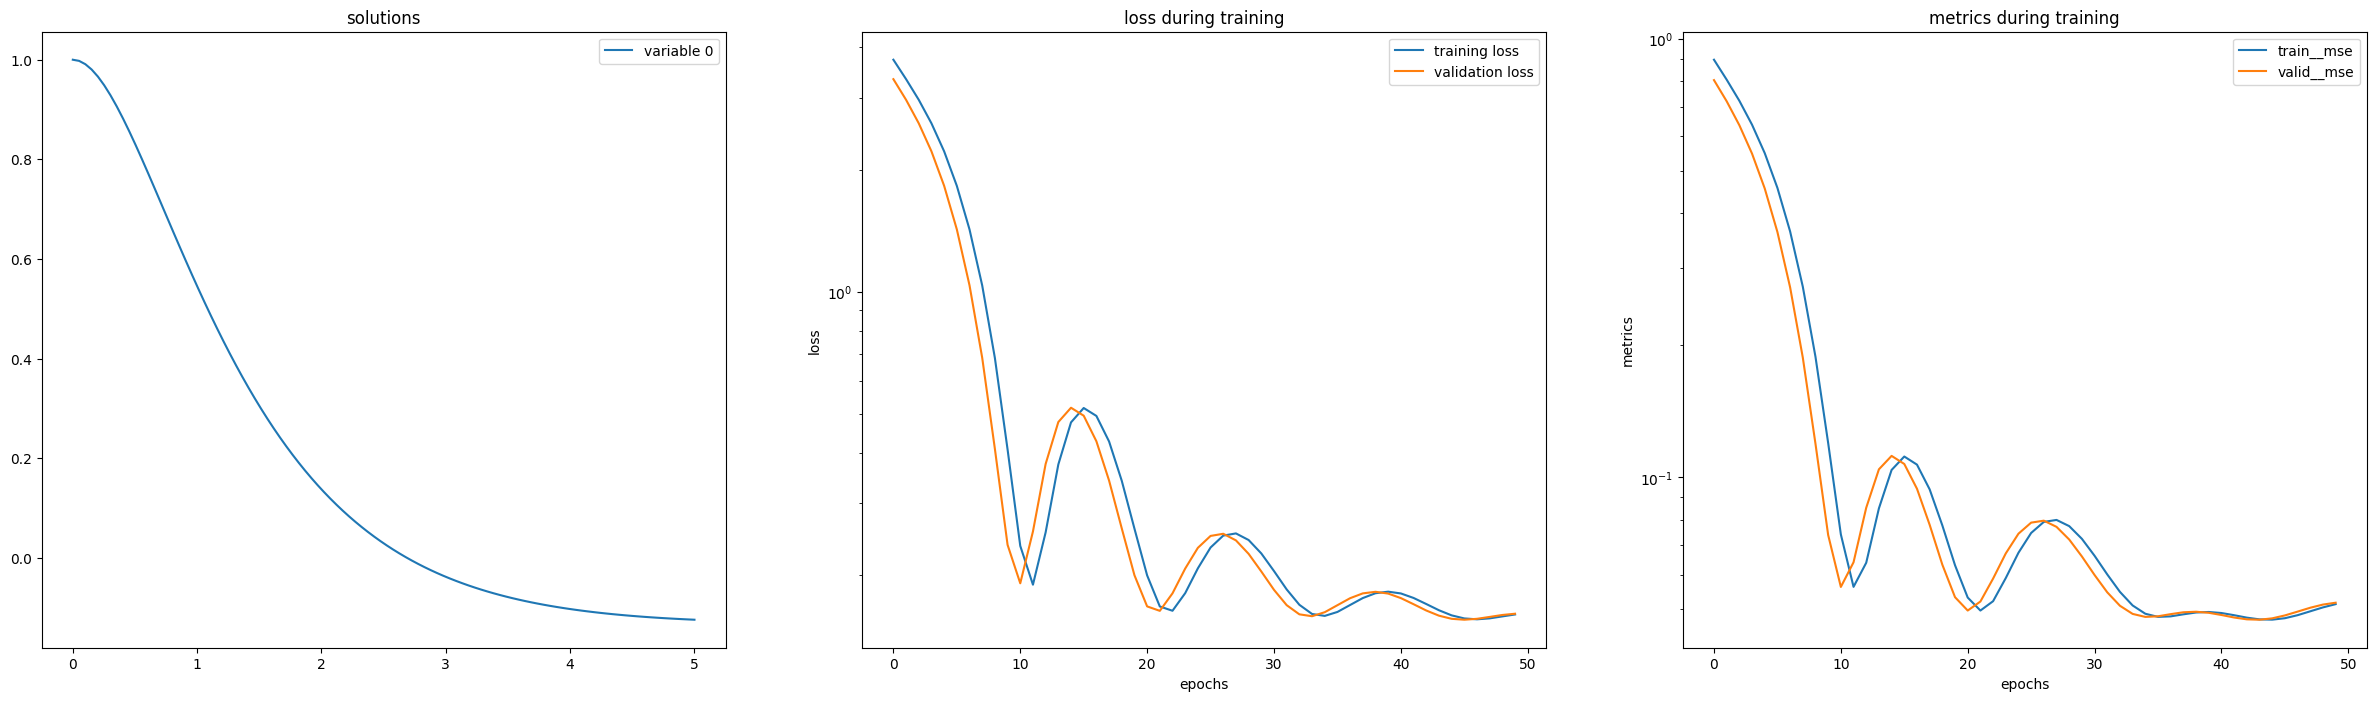

In [35]:
#monitor를 위한 설정을 생성합니다.
monitor = nde.monitors.Monitor1D(t_min=0, t_max=5, check_every=50)
monitor_callback = monitor.to_callback()

# Solver1D 클래스의 인스턴스를 생성하여 미분 방정식을 풀고 훈련합니다.
solver = nde.solvers.Solver1D(ode_system, conditions=initial_condition, nets=neural_net,
                              train_generator=train_gen, valid_generator=valid_gen, metrics=metrics)
sol = solver.fit(max_epochs=500, callbacks=[monitor_callback])

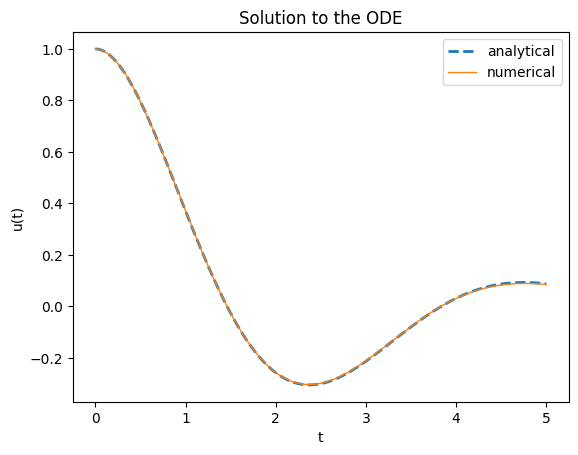

In [36]:
# 결과 시각화
t = torch.linspace(0, 5, 1000)

#analytical graph
#sol_anal = lambda t :np.sin(t)
sol_anal = lambda t :\
    np.exp(-t/2.) * (np.cos(np.sqrt(7) * t / 2.) + np.sin(np.sqrt(7) * t / 2.)/np.sqrt(7.))
u_anal = sol_anal(t)

solution = solver.get_solution()
u_pred = solution(t).detach().numpy()
plt.plot(t, u_anal, '--', linewidth=2, label='analytical')
plt.plot(t, u_pred, linewidth=1, label='numerical')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution to the ODE')
plt.legend()
plt.show()